# Regression between vertical motion and longwave/shortwave radiation

## Import package

In [86]:
import h5py
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt

## Load data

In [87]:
# Load CloudSat radiation
## Load composited radiation profile
lw_comp = {}
sw_comp = {}

with h5py.File("/work/b11209013/2025_Research/regression/IMERG_CLOUDSAT.h5", "r") as f:
    lw_comp_grp = f["lw_composite"]
    sw_comp_grp = f["sw_composite"]

    for key in lw_comp_grp.keys():
        lw_comp[key] = np.array(lw_comp_grp.get(key))
        sw_comp[key] = np.array(sw_comp_grp.get(key))

# Load ERA5 w
w_comp = {}

with h5py.File("/work/b11209013/2025_Research/regression/IMERG_ERA5.h5", "r") as f:
    w_comp_grp = f["w_composite"]

    for key in w_comp_grp.keys():
        w_comp[key] = np.array(w_comp_grp.get(key))

print(w_comp["mjo_1_4"].shape)

(37, 576)


## Calculate linear response function between ERA5 and CloudSat

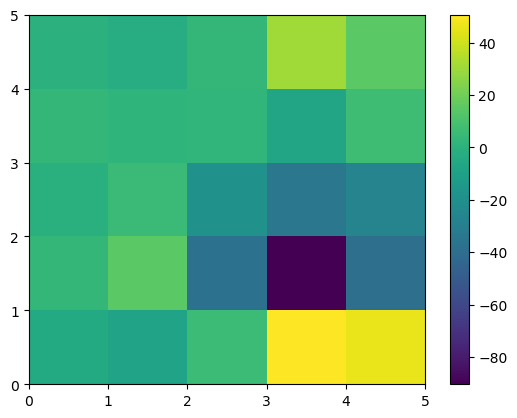

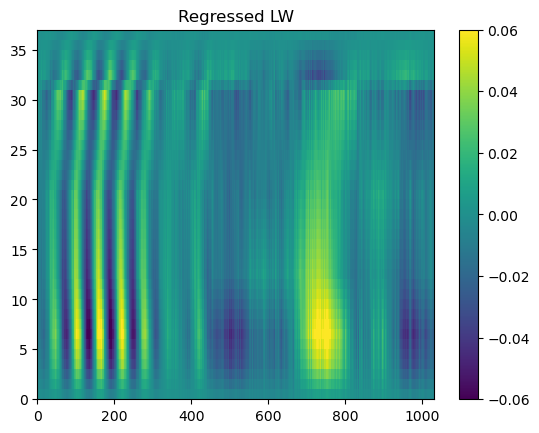

Text(0.5, 1.0, 'Original LW')

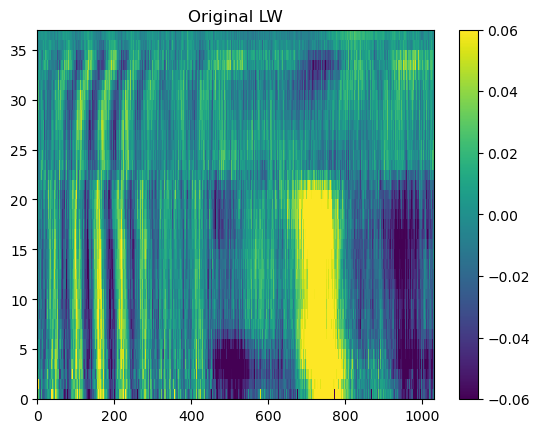

In [88]:
# concatenate data
lw = np.concatenate([lw_comp[key] for key in lw_comp.keys()], axis=1)
sw = np.concatenate([sw_comp[key] for key in sw_comp.keys()], axis=1)
w = np.concatenate([w_comp[key] for key in w_comp.keys()], axis=1) # shape: (n_samples, nz)

lw -= np.mean(lw, axis=1, keepdims=True)
sw -= np.mean(sw, axis=1, keepdims=True)
w -= np.mean(w, axis=1, keepdims=True)

lw_train = lw[:, :3000].T
sw_train = sw[:, :3000].T
w_train = w[:, :3000].T

# apply EOF on w
w_U, w_S, w_Vt = np.linalg.svd(w_train, full_matrices=False)
w_eofs = w_Vt[:5, :] # shape (nmodes, nz)
w_pcs = (w_train @ w_eofs.T @ np.linalg.inv(w_eofs @ w_eofs.T)).T # shape (nmodes, n_samples)

# decompose lw and sw using w EOFs
lw_pcs = (lw_train @ w_eofs.T @ np.linalg.inv(w_eofs @ w_eofs.T)).T  # shape (nmodes, n_samples)
sw_pcs = (sw_train @ w_eofs.T @ np.linalg.inv(w_eofs @ w_eofs.T)).T  # shape (nmodes, n_samples)

# apply regression
lw_w = lw_pcs @ w_pcs.T @ np.linalg.inv(w_pcs @ w_pcs.T)  # shape (nz, nmodes)
sw_w = sw_pcs @ w_pcs.T @ np.linalg.inv(w_pcs @ w_pcs.T)  # shape (nz, nmodes)

# test
lw_test = lw[:, 3000:].T
sw_test = sw[:, 3000:].T
w_test = w[:, 3000:].T

w_test_pcs = (w_test @ w_eofs.T @ np.linalg.inv(w_eofs @ w_eofs.T)).T
lw_test_pcs = (lw_test @ w_eofs.T @ np.linalg.inv(w_eofs @ w_eofs.T)).T
sw_test_pcs = (sw_test @ w_eofs.T @ np.linalg.inv(w_eofs @ w_eofs.T)).T

lw_reg = w_eofs.T @ (lw_w @ w_test_pcs)

plt.pcolormesh(lw_w)
plt.colorbar()
plt.show()  

plt.pcolormesh(lw_reg, vmin=-0.06, vmax=0.06)
plt.colorbar()
plt.title("Regressed LW")
plt.show()
plt.pcolormesh(lw_test.T, vmin=-0.06, vmax=0.06)
plt.colorbar()
plt.title("Original LW")

## Save File

In [90]:
with h5py.File("/home/b11209013/2025_Research/Obs/Files/ERA5/LRF_w.h5", "w") as f:
    f.create_dataset("LW_LRF", data=lw_w)
    f.create_dataset("SW_LRF", data=sw_w)
    f.create_dataset("EOF", data=w_eofs)

print("Shape of eof:", w_eofs.shape)

Shape of eof: (5, 37)
